In [47]:
import numpy as np 
import pygame
import math 
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize randomness and board features
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

ROW = 6
COLUMN = 7
SQUARESIZE = 100
RADIUS = int(SQUARESIZE/2 - 5)
BLUE = (0, 0, 225) 
BLACK = (0, 0, 0) 
RED = (255, 0, 0)
YELLOW = (255, 255, 0) 

**Research questions:**
- “Can our agent learn to play better than a static baseline?”
- “How does performance change with different ε strategies?”
- “How does our agent play against a minimax or random opponent?”

**Why Q learning for this project instead of SARSA?**

 Q learning is a better fit for this project because it learns off policy, meaning it updates toward the best possible next action rather than the specific exploratory action taken during training. This leads to stronger and more optimal play in environments like Connect Four where exploration does not carry risk and rewards come mostly at the end of the game. SARSA tends to learn safer on policy behavior that is more useful in environments where exploration can lead to bad outcomes. For this project, Q learning is simpler to implement, more stable against random opponents, and better aligned with the goal of learning a competitive policy.

# Helper functions

In [48]:
# Checks to see if we can drop a piece in a given column
def validLocation(board, col): 
    return board[ROW - 1][col] == 0


def placePiece(board, row, col, piece): 
    board[row][col] = piece

def nextRow(board, col): 
    for r in range(ROW):
        if board[r][col] == 0: 
            return r

def get_valid_actions(board):
    return [col for col in range(COLUMN) if validLocation(board, col)]

# Used in random agent implementation 
def random_agent_move(board):
    valid_cols = get_valid_actions(board)
    return np.random.choice(valid_cols)

# Encode the board as a tuple so it can be a dict key
def encode_state(board):
    # Flatten 6x7 -> length-42 tuple of ints
    return tuple(board.flatten())

# Used in minimax implementation
def simulate_move(board, col, piece):
    # Make a copy
    temp_board = board.copy()

    # Find where this piece will land in the column
    row = nextRow(temp_board, col)

    # Place the piece
    placePiece(temp_board, row, col, piece)

    # Return the new board state
    return temp_board

# Used in RL implementation: Q-learning loop
def step(board, action, player):
    # copy so we don't mutate original
    next_board = board.copy()

    # apply action
    row = nextRow(next_board, action)
    placePiece(next_board, row, action, player)

    # check terminal (win/loss/draw)
    if winningMove(next_board, player):
        return next_board, 1, True   # reward for win

    if len(get_valid_actions(next_board)) == 0:
        return next_board, 0, True   # draw

    # non-terminal step
    return next_board, 0, False

def is_terminal_node(board):
    return winningMove(board, 1) or winningMove(board, 2) or len(get_valid_actions(board)) == 0

# For minimax heuristic
# assumes “AI” = piece 1, “opponent” = piece 2. Can be tuned if we want later. 
def minimax_evaluate(board, ai_piece=1):
    """
    Heuristic evaluation used ONLY by minimax.
    Scores the board from the perspective of ai_piece.
    """
    opp_piece = 2 if ai_piece == 1 else 1

    if winningMove(board, ai_piece):
        return 1000000
    if winningMove(board, opp_piece):
        return -1000000

    return 0

# Resets the board (np array) to 0s
def reset():
    return np.zeros((6,7), dtype=int)

# Checks to see if a move is a winning move (connect four game logic)
def winningMove(board, piece):
    # Check horizontal 
    for r in range(ROW):
        for c in range(COLUMN - 3):
            if np.all(board[r, c:c+4] == piece):
                return True

    # Check vertical 
    for c in range(COLUMN):
        for r in range(ROW - 3):
            if np.all(board[r:r+4, c] == piece):
                return True
                
    # Check positive diagonal 
    for r in range(ROW - 3):
        for c in range(COLUMN - 3):
            if all(board[r+i, c+i] == piece for i in range(4)):
                return True

    # Check negative diagonal 
    for r in range(3, ROW):
        for c in range(COLUMN - 3):
            if all(board[r-i, c+i] == piece for i in range(4)):
                return True

    return False

In [49]:
# Basic test of helper functions...can remove after confirming functionality 
def play_random_game(verbose=False):
    board = reset()
    player = 1
    done = False

    while not done:
        action = random_agent_move(board)
        board, reward, done = step(board, action, player)

        if verbose:
            print("Player", player, "plays", action)
            print(np.flip(board, 0))
            print()

        if done:
            if reward == 1:
                print("Player", player, "wins!")
            else:
                print("Draw!")
            break

        # swap players: 1 <-> 2
        player = 2 if player == 1 else 1

play_random_game(verbose=True)

Player 1 plays 6
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]]

Player 2 plays 3
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 2 0 0 1]]

Player 1 plays 4
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 2 1 0 1]]

Player 2 plays 6
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2]
 [0 0 0 2 1 0 1]]

Player 1 plays 2
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2]
 [0 0 1 2 1 0 1]]

Player 2 plays 4
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 2 0 2]
 [0 0 1 2 1 0 1]]

Player 1 plays 4
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 2 0 2]
 [0 0 1 2 1 0 1]]

Player 2 plays 6
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 2]
 [0 0 0 0 2 0 2]
 [0 0 1 2 1 0 1]]

Player 1 plays 1
[[0 0 0 0 0 0 0

# RL Agent Training loops
## RL Agent A (Fixed epsilon)
- Trained with constant ε = 0.1
- Stored in Q_fixed
- Learning history in wins_fixed

## RL Agent B (Decaying epsilon)
- Starts ε = 1.0, decays to 0.1
- Stored in Q_decay
- Learning history in wins_decay

In [50]:
# Q-table: dict[(state_tuple, action_int)] -> float
Q = {}  # you will likely create this inside train_q_agent

def get_Q(Q, state, action):
    return Q.get((state, action), 0.0)

def set_Q(Q, state, action, value):
    Q[(state, action)] = value

def epsilon_greedy_policy(Q, board, epsilon):
    state = encode_state(board)
    valid_actions = get_valid_actions(board)

    # With prob epsilon, explore
    if random.random() < epsilon:
        return random.choice(valid_actions)

    # Otherwise, exploit: choose action with max Q
    best_value = None
    best_actions = []

    for a in valid_actions:
        q = get_Q(Q, state, a)
        if (best_value is None) or (q > best_value):
            best_value = q
            best_actions = [a]
        elif q == best_value:
            best_actions.append(a)

    # Break ties randomly
    return random.choice(best_actions)

def q_learning_update(Q, state, action, reward, next_board, alpha, gamma, done):
    """
    state: encoded state (tuple)
    action: int column
    reward: scalar
    next_board: numpy board after the move
    done: True if episode finished
    """
    old_q = get_Q(Q, state, action)

    if done:
        target = reward
    else:
        next_state = encode_state(next_board)
        valid_next_actions = get_valid_actions(next_board)
        if not valid_next_actions:  # no moves left
            target = reward
        else:
            max_next_q = max(get_Q(Q, next_state, a) for a in valid_next_actions)
            target = reward + gamma * max_next_q

    new_q = old_q + alpha * (target - old_q)
    set_Q(Q, state, action, new_q)

def train_q_agent(num_episodes, epsilon_schedule, alpha=0.1, gamma=0.95):
    Q = {}
    win_history = []  # store 1 for RL win, 0 for loss/draw for tracking

    for episode in range(num_episodes):
        board = reset()
        player = 1  # RL always starts for now
        done = False

        # For RL, track last (s, a) so we can assign loss if random wins
        last_state = None
        last_action = None

        epsilon = epsilon_schedule(episode, num_episodes)

        rl_won = 0  # for stats

        while not done:
            if player == 1:
                # RL's turn
                state = encode_state(board)
                action = epsilon_greedy_policy(Q, board, epsilon)

                next_board, reward, done = step(board, action, player)

                # If RL wins immediately
                if done:
                    # reward = +1 from step(), episode ends
                    q_learning_update(Q, state, action, reward, next_board,
                                      alpha, gamma, done=True)
                    if reward == 1:
                        rl_won = 1
                    break
                else:
                    # Not terminal yet, so intermediate reward = 0
                    q_learning_update(Q, state, action, 0, next_board,
                                      alpha, gamma, done=False)
                    last_state = state
                    last_action = action
                    board = next_board
                    player = 2  # random's turn

            else:
                # Random agent turn (Player 2)
                action = random_agent_move(board)
                next_board, reward, done = step(board, action, player)

                if done:
                    # If random wins, reward=1 for player 2 -> RL lost
                    if reward == 1:
                        # Penalize RL's last move with -1
                            # (if RL has made any move in this episode)
                        if last_state is not None and last_action is not None:
                            q_learning_update(Q, last_state, last_action,
                                              -1, next_board,
                                              alpha, gamma, done=True)
                        rl_won = 0
                    else:
                        # draw: reward 0 to RL
                        if last_state is not None and last_action is not None:
                            q_learning_update(Q, last_state, last_action,
                                              0, next_board,
                                              alpha, gamma, done=True)
                    break
                else:
                    # Game continues, no update for RL here
                    board = next_board
                    player = 1  # back to RL

        win_history.append(rl_won)

    return Q, win_history

def epsilon_fixed(episode, total_episodes, value=0.1):
    return value

def epsilon_linear_decay(episode, total_episodes, eps_start=1.0, eps_end=0.1):
    frac = episode / float(total_episodes)
    return eps_start + (eps_end - eps_start) * frac

In [51]:
num_episodes = 50000  # can be tuned

Q_fixed, wins_fixed = train_q_agent(num_episodes, epsilon_fixed)
Q_decay, wins_decay = train_q_agent(num_episodes, epsilon_linear_decay)

We trained and evaluated the RL agent as Player 1. Because the state representation is not player-invariant, we did not use the agent as Player 2 due to time constraints and our research questions. 

## Plot Training Data
**Note:**  
The y-axis shows the smoothed win rate, calculated using a moving average over a 500-episode window.  
Each episode is a binary outcome (1 = win, 0 = loss/draw), which creates a noisy signal.  
Smoothing highlights the underlying learning trend and allows for clear comparison between the fixed and decaying epsilon strategies.

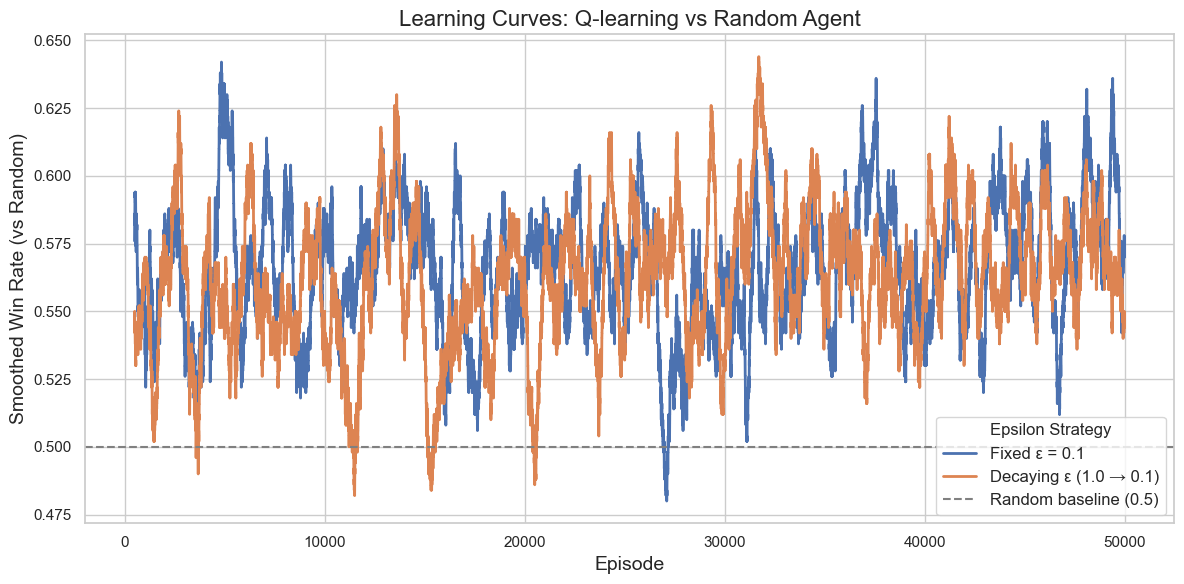

In [52]:
sns.set(style="whitegrid")

def make_learning_df(wins_list, label, window=500):
    """
    Take a list of binary win/loss outcomes and return a dataframe
    with a smoothed moving average win rate.
    """
    wins = np.array(wins_list)

    if len(wins) >= window:
        ma = np.convolve(wins, np.ones(window) / window, mode="valid")
        episodes = np.arange(window, window + len(ma))
    else:
        ma = wins
        episodes = np.arange(1, len(ma) + 1)

    return pd.DataFrame({
        "episode": episodes,
        "win_rate": ma,
        "agent": label
    })

# Build combined learning dataframe
df_fixed = make_learning_df(wins_fixed, "Fixed ε = 0.1", window=500)
df_decay = make_learning_df(wins_decay, "Decaying ε (1.0 → 0.1)", window=500)

df_learning = pd.concat([df_fixed, df_decay], ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=df_learning,
    x="episode",
    y="win_rate",
    hue="agent",
    linewidth=2
)

# Add random baseline at 0.5
ax.axhline(0.5, ls="--", color="gray", linewidth=1.5, label="Random baseline (0.5)")

ax.set_title("Learning Curves: Q-learning vs Random Agent", fontsize=16)
ax.set_xlabel("Episode", fontsize=14)
ax.set_ylabel("Smoothed Win Rate (vs Random)", fontsize=14)

plt.legend(title="Epsilon Strategy", fontsize=12)
plt.tight_layout()
plt.show()

We found that both fixed and decaying epsilon strategies produced similar win-rate curves, suggesting that exploration schedule has limited impact in this high-dimensional, sparse-reward environment. We would need a more complex adaption of the Q-learning algorithm than the tabular version we learned in class. We upped the number of episodes from 20k to 50k to get more information and see if it helps the win rate improve even slightly. 

# Evaluation
Testing each RL agent against random agents and minimax agents.

## Evaluation against Random Agent

In [53]:
# Choose best move, don't explore
def rl_greedy_action(Q, board):
    state = encode_state(board)
    valid_actions = get_valid_actions(board)
    
    # If somehow no valid actions, just return None (shouldn't really happen)
    if not valid_actions:
        return None
    
    best_value = -1e9
    best_actions = []
    
    for a in valid_actions:
        q = get_Q(Q, state, a)
        if q > best_value:
            best_value = q
            best_actions = [a]
        elif q == best_value:
            best_actions.append(a)
    
    return random.choice(best_actions)

def evaluate_vs_random(Q, num_games=200):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_games):
        board = reset()
        player = 1  # RL is always player 1
        done = False

        while not done:
            if player == 1:
                action = rl_greedy_action(Q, board)
            else:
                action = random_agent_move(board)

            board, reward, done = step(board, action, player)

            if done:
                if reward == 1 and player == 1:
                    wins += 1
                elif reward == 1 and player == 2:
                    losses += 1
                else:
                    draws += 1
                break

            # swap players
            player = 2 if player == 1 else 1

    return wins, losses, draws

Fixed ε win rate: 0.578
Decaying ε win rate: 0.5526666666666666


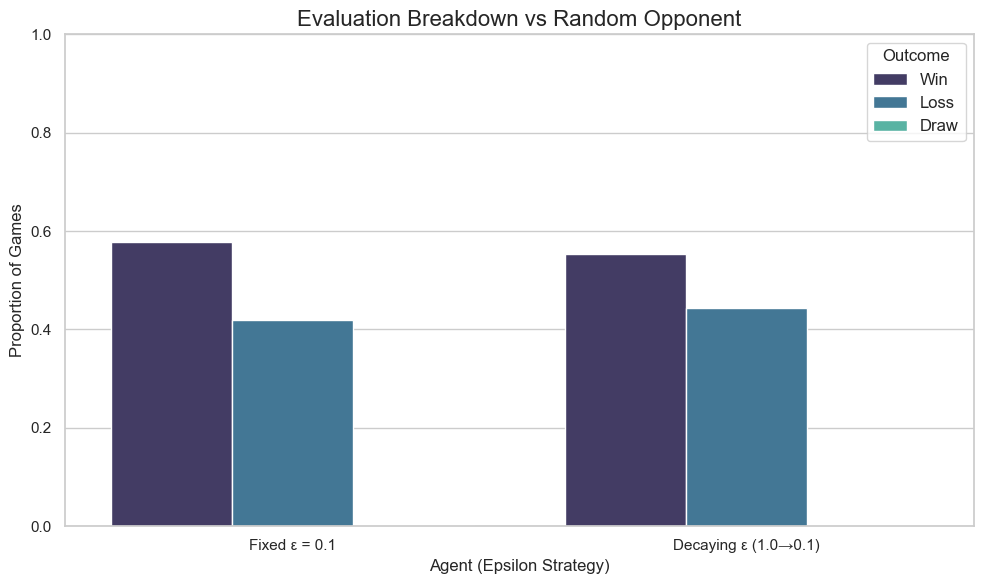

In [54]:
w_fixed, l_fixed, d_fixed = evaluate_vs_random(Q_fixed, num_games=3000)
w_decay, l_decay, d_decay = evaluate_vs_random(Q_decay, num_games=3000)

print("Fixed ε win rate:", w_fixed / (w_fixed + l_fixed + d_fixed))
print("Decaying ε win rate:", w_decay / (w_decay + l_decay + d_decay))

# Build full results DataFrame
df_eval_full = pd.DataFrame({
    "Agent": [
        "Fixed ε = 0.1", "Fixed ε = 0.1", "Fixed ε = 0.1",
        "Decaying ε (1.0→0.1)", "Decaying ε (1.0→0.1)", "Decaying ε (1.0→0.1)"
    ],
    "Result": ["Win", "Loss", "Draw"] * 2,
    "Rate": [
        w_fixed  / (w_fixed + l_fixed + d_fixed),
        l_fixed  / (w_fixed + l_fixed + d_fixed),
        d_fixed  / (w_fixed + l_fixed + d_fixed),

        w_decay  / (w_decay + l_decay + d_decay),
        l_decay  / (w_decay + l_decay + d_decay),
        d_decay  / (w_decay + l_decay + d_decay),
    ]
})

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_eval_full,
    x="Agent",
    y="Rate",
    hue="Result",
    palette="mako"
)

ax.set_title("Evaluation Breakdown vs Random Opponent", fontsize=16)
ax.set_ylim(0, 1)
ax.set_ylabel("Proportion of Games", fontsize=12)
ax.set_xlabel("Agent (Epsilon Strategy)", fontsize=12)
plt.legend(title="Outcome", fontsize=12)

plt.tight_layout()
plt.show()

## Evaluation against Minimax Agent

In [56]:
def minimax_alpha_beta(board, depth, alpha, beta, maximizing_player, ai_piece):
    valid_locations = get_valid_actions(board)
    terminal = is_terminal_node(board)

    if depth == 0 or terminal:
        return minimax_evaluate(board, ai_piece), None

    opp_piece = 2 if ai_piece == 1 else 1

    if maximizing_player:
        value = -np.inf
        best_col = random.choice(valid_locations)
        for col in valid_locations:
            child_board = simulate_move(board, col, ai_piece)
            new_score, _ = minimax_alpha_beta(child_board, depth - 1, alpha, beta,
                                              False, ai_piece)
            if new_score > value:
                value = new_score
                best_col = col
            alpha = max(alpha, value)
            if alpha >= beta:
                break  # beta cut-off
        return value, best_col
    else:
        value = np.inf
        best_col = random.choice(valid_locations)
        for col in valid_locations:
            child_board = simulate_move(board, col, opp_piece)
            new_score, _ = minimax_alpha_beta(child_board, depth - 1, alpha, beta,
                                              True, ai_piece)
            if new_score < value:
                value = new_score
                best_col = col
            beta = min(beta, value)
            if alpha >= beta:
                break  # alpha cut-off
        return value, best_col

def evaluate_vs_minimax(Q, num_games=200, depth=3):
    """
    Evaluate a trained RL agent (greedy policy, ε=0) vs a minimax agent.
    RL is always Player 1 (piece = 1).
    Minimax is always Player 2 (piece = 2).

    Returns:
        wins, losses, draws
    """
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_games):
        board = reset()
        player = 1  # RL starts first
        done = False

        while not done:
            if player == 1:
                # RL agent using greedy policy (ε = 0)
                action = rl_greedy_action(Q, board)
            else:
                # Minimax agent as Player 2
                action = minimax_agent_move(board, piece=2, depth=depth)

            board, reward, done = step(board, action, player)

            if done:
                # Determine outcome by examining final board
                if winningMove(board, 1):      # RL wins
                    wins += 1
                elif winningMove(board, 2):    # Minimax wins
                    losses += 1
                else:                          # Draw
                    draws += 1
                break

            # Switch turns
            player = 2 if player == 1 else 1

    return wins, losses, draws

def minimax_agent_move(board, piece=2, depth=3):
    """
    Choose a move for a minimax agent playing as 'piece' (1 or 2).
    Default: piece=2 so minimax is Player 2 vs RL as Player 1.
    """
    _, best_col = minimax_alpha_beta(board, depth, -np.inf, np.inf,
                                     maximizing_player=True, ai_piece=piece)
    return best_col

Fixed ε win rate vs minimax: 0.102
Decaying ε win rate vs minimax: 0.07666666666666666


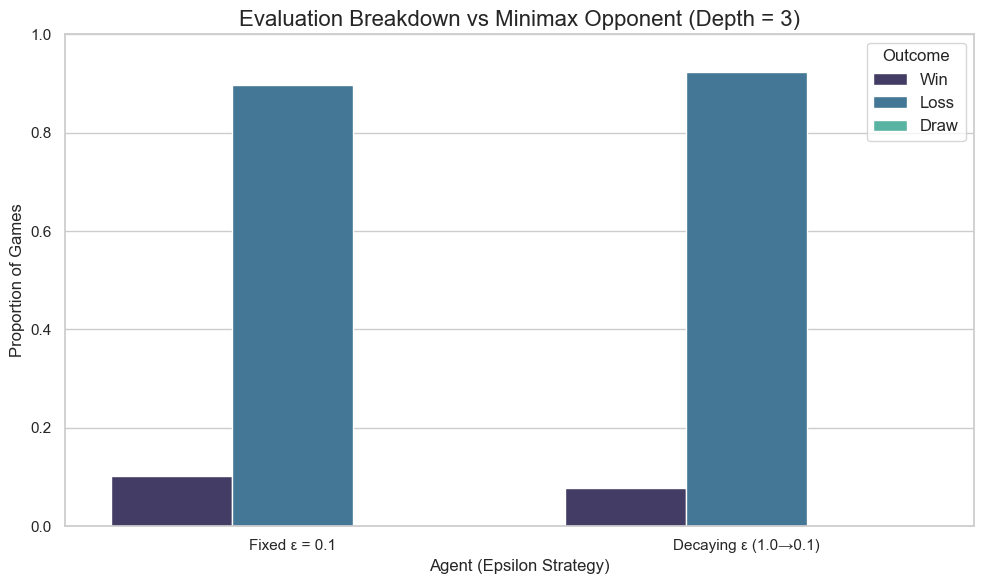

In [57]:
# Evaluate each trained agent vs a minimax opponent
w_fixed_m, l_fixed_m, d_fixed_m = evaluate_vs_minimax(Q_fixed, num_games=3000, depth=3)
w_decay_m, l_decay_m, d_decay_m = evaluate_vs_minimax(Q_decay, num_games=3000, depth=3)

print("Fixed ε win rate vs minimax:",  w_fixed_m  / (w_fixed_m  + l_fixed_m  + d_fixed_m))
print("Decaying ε win rate vs minimax:", w_decay_m / (w_decay_m + l_decay_m + d_decay_m))

# Build full results DataFrame for minimax evaluation
df_eval_minimax = pd.DataFrame({
    "Agent": [
        "Fixed ε = 0.1", "Fixed ε = 0.1", "Fixed ε = 0.1",
        "Decaying ε (1.0→0.1)", "Decaying ε (1.0→0.1)", "Decaying ε (1.0→0.1)"
    ],
    "Result": ["Win", "Loss", "Draw"] * 2,
    "Rate": [
        w_fixed_m  / (w_fixed_m + l_fixed_m + d_fixed_m),
        l_fixed_m  / (w_fixed_m + l_fixed_m + d_fixed_m),
        d_fixed_m  / (w_fixed_m + l_fixed_m + d_fixed_m),

        w_decay_m / (w_decay_m + l_decay_m + d_decay_m),
        l_decay_m / (w_decay_m + l_decay_m + d_decay_m),
        d_decay_m / (w_decay_m + l_decay_m + d_decay_m),
    ]
})

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_eval_minimax,
    x="Agent",
    y="Rate",
    hue="Result",
    palette="mako"
)

ax.set_title("Evaluation Breakdown vs Minimax Opponent (Depth = 3)", fontsize=16)
ax.set_ylim(0, 1)
ax.set_ylabel("Proportion of Games", fontsize=12)
ax.set_xlabel("Agent (Epsilon Strategy)", fontsize=12)
plt.legend(title="Outcome", fontsize=12)

plt.tight_layout()
plt.show()

The above code may take 15-20 min to run due to the complexity of the game. This is normal given a brute force approach.

# Final Demo (TO BE FINISHED)

Some notes on the implementation (Sam):

In order for a human to play against one of the agents, the agent should be assigned to Player 1, since that is the role it was trained for. The human would take the position of Player 2. The game loop remains the same as in training and evaluation, but instead of selecting an action for Player 2 from an automated policy, the program would prompt the user to enter a column number. Each turn, the board would be printed to the screen, and when it is the human’s turn, they would type a valid column (0–6). When it is the agent’s turn, the agent selects a column automatically. The game continues alternating turns until a win, loss, or draw is detected and the final board is displayed.

In [7]:
def drawBoard(board): 
    for c in range(COLUMN):
        for r in range(ROW):
            pygame.draw.rect(screen, BLUE, (c*SQUARESIZE, r*SQUARESIZE+SQUARESIZE, SQUARESIZE, SQUARESIZE))
            pygame.draw.circle(screen, BLACK, (int(c*SQUARESIZE+SQUARESIZE/2), int(r*SQUARESIZE+SQUARESIZE+SQUARESIZE/2)), RADIUS)
     
    for c in range(COLUMN):
        for r in range(ROW):      
            if board[r][c] == 1:
                pygame.draw.circle(screen, RED, (int(c*SQUARESIZE+SQUARESIZE/2), height-int(r*SQUARESIZE+SQUARESIZE/2)), RADIUS)
            elif board[r][c] == 2: 
                pygame.draw.circle(screen, YELLOW, (int(c*SQUARESIZE+SQUARESIZE/2), height-int(r*SQUARESIZE+SQUARESIZE/2)), RADIUS)
    pygame.display.update()

def printBoard(board):
    print(np.flip(board, 0))

In [8]:
board = np.zeros((6,7))
printBoard(board)
gameOver = False
running = True
turn = 0 

pygame.init()
width = COLUMN * SQUARESIZE
height = (ROW + 1) * SQUARESIZE
size = (width, height)
screen = pygame.display.set_mode(size)

drawBoard(board)
pygame.display.update()
myfont = pygame.font.SysFont("monospace", 75)

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False 

        if event.type == pygame.MOUSEBUTTONDOWN and not gameOver:
            pygame.draw.rect(screen, BLACK, (0,0, width, SQUARESIZE))
            if turn == 0:
                posx = event.pos[0]
                col = int(math.floor(posx/SQUARESIZE))
                basicAI(board, col)
                if winningMove(board, 1):
                    label = myfont.render("Player 1 wins!!", 1, RED)
                    screen.blit(label, (40,10))
                    gameOver = True
            else:     
                posx = event.pos[0]
                col = int(math.floor(posx/SQUARESIZE))
                advAI(board, col)
                if winningMove(board, 2):
                    label = myfont.render("Player 2 wins!!", 1, YELLOW)
                    screen.blit(label, (40,10))
                    gameOver = True
 
            printBoard(board)
            drawBoard(board)
 
            turn += 1
            turn = turn % 2
 
            if gameOver:
                pygame.display.update()

    pygame.display.update()

pygame.quit()

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
